In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01f0)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001f0,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 10, use_cuda = true)

Args(0.0003, 128, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [11]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [14]:
x0 |> size

(28, 28, 128)

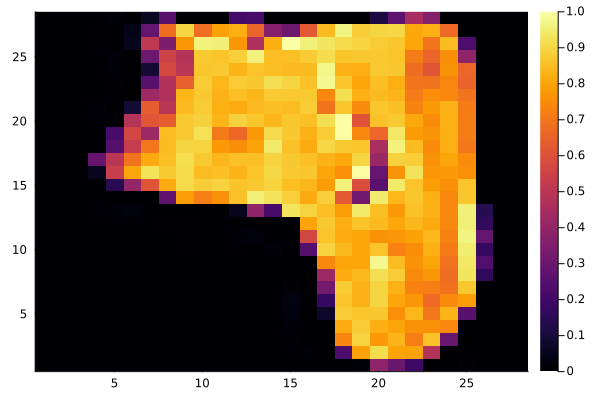

In [15]:
heatmap(x0[:,:,1])

# Test Phasor network

In [16]:
import .PhasorNetworks: default_bias

In [20]:
n_vsa = 128

128

In [21]:
p_model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorConv((16, 16), 1 => 3, soft_angle),
            PhasorConv((8, 8), 3 => 1, soft_angle),
            FlattenLayer(),
            PhasorDense(36 => n_vsa, soft_angle),
            Codebook(n_vsa => 10),
            )

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#37),
    layer_3 = WrappedFunction(#38),
    layer_4 = WrappedFunction(#39),
    layer_5 = PhasorConv(
        layer = Conv((16, 16), 1 => 3, use_bias=false),  # 768 parameters
        bias = ComplexBias((1, 1, 3)),            # 6 parameters
    ),
    layer_6 = PhasorConv(
        layer = Conv((8, 8), 3 => 1, use_bias=false),  # 192 parameters
        bias = ComplexBias((1, 1, 1)),            # 2 parameters
    ),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = PhasorDense(
        layer = Dense(36 => 128, use_bias=false),  # 4_608 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_9 = Codebook(128 => 10),
)         # Total: 7_400 parameters,
          #        plus 1_280 states.

In [22]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.023431744 -0.05666465 … 0.035865206 0.08362411; 0.07112079 -0.036560196 … -0.07030682 -5.074161f-5; … ; 0.0335548 0.08311894 … 0.067926824 -0.03217039; 0.05536266 0.09275273 … 0.07492148 0.090133645;;;; -0.009629318 0.031081224 … -0.021675674 -0.06745764; -0.10271195 0.029200751 … 0.09133045 0.046942662; … ; -0.04849917 -0.0891583 … -0.082933895 0.10428459; 0.09495854 0.0017096903 … 0.021213438 0.09185998;;;; 0.0915087 -0.07424506 … 0.02655549 0.09911553; 0.09544555 0.063494325 … -0.01567748 -0.088646404; … ; 0.049645517 -0.10429867 … 0.10311277 -0.09001123; -0.09125064 -0.016199492 … -0.102465846 0.0943015],), bias = (bias_real = Float32[1.0;;; 1.0;;; 1.0], bias_imag

In [23]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[-0.058627706 0.04253671 … 0.04177859 0.05727955; -0.10925829 -0.0283018 … -0.08656654 -0.069672115; … ; 0.0421181 0.01997477 … 0.059503064 0.02509141; 0.10577994 0.114382535 … 0.16313267 0.13149309], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = (dense = NamedTuple(), bias = NamedTuple()), layer_9 = (codes = Float32[0.32808685 0.19411194 … 0.9838135 0.24472547; 0.8300173 -0.39028752 … -0.87215006 0.044412374; … ; -0.9538424 0.018405676 … 0.69616556 0.9596149; 0.68974876 -0.17169476 … -0.98557794 -0.8883637],)))

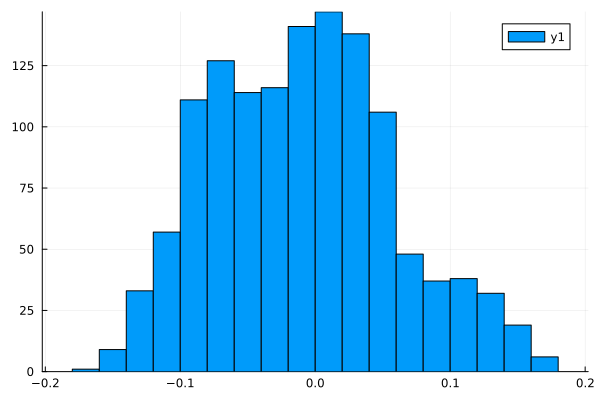

In [24]:
histogram(cdev(vec(yp0)))

In [25]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = codebook_loss(y_pred, y_onehot) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [26]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

1.0125422237391488

In [27]:
@time losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

[ Info: Training on CUDA GPU


103.374128 seconds (265.79 M allocations: 12.816 GiB, 1.92% gc time, 1 lock conflict, 26.80% compilation time)


(Any[1.0125422239088646, 1.0162720272097654, 1.0050463002823296, 0.9954866986948929, 0.9782849002056746, 0.9783467930908611, 0.9731071744884847, 0.9937953141534781, 0.9731513340654454, 0.9848968289659534  …  0.18363297106704662, 0.17772547639337752, 0.1665046901864029, 0.18093771369815626, 0.18448818670693024, 0.18492458169870882, 0.17543746182981618, 0.16792867726662764, 0.16258736301207266, 0.19174689936106523], (layer_1 = (bias = Float32[0.22381529 -0.26316494 … -0.09867797 0.0031233157; -0.45302218 -0.5284274 … 0.15585735 -0.0836155; … ; 0.39001715 0.23882164 … 0.07012527 0.42104477; 0.40263104 -0.20124528 … 0.033259008 0.2101781;;;], scale = Float32[0.7729116 1.2600898 … 1.1127093 0.9960793; 1.4502964 1.5222276 … 0.84884274 1.072974; … ; 0.60754436 0.760824 … 0.90211123 0.5743493; 0.5947465 1.2093053 … 0.94812864 0.7866892;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.0033769207 -0.08990092 … 0.07949083 0.11559

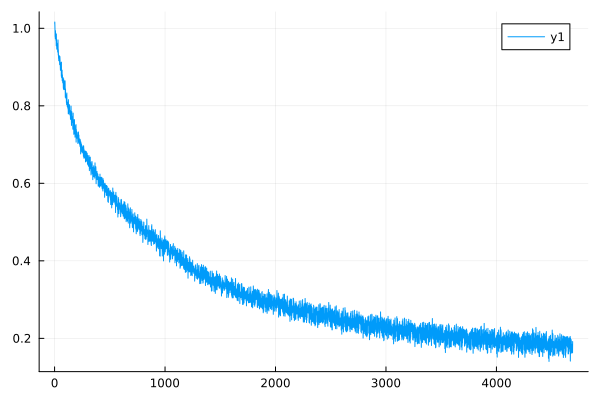

In [28]:
#plot(losses)
plot(losses_f)

In [29]:
yp1, _ = p_model(x0 |> gdev, ps_train_f, st_train_f) 

(Float32[0.0063452553 0.7109754 … 0.10256536 0.6492338; -0.0054071154 0.019491555 … 0.0028750394 0.09217882; … ; 0.14894244 0.10599458 … 0.14727107 0.07361634; 0.8269768 0.02940525 … 0.11535813 -0.011710901], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = (dense = NamedTuple(), bias = NamedTuple()), layer_9 = (codes = Float32[0.32808685 0.19411194 … 0.9838135 0.24472547; 0.8300173 -0.39028752 … -0.87215006 0.044412374; … ; -0.9538424 0.018405676 … 0.69616556 0.9596149; 0.68974876 -0.17169476 … -0.98557794 -0.8883637],)))

In [30]:
size(yp1)

(10, 128)

In [31]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_codebook(cdev(y_pred), dims=1)
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [32]:
test_phasor(p_model, test_loader, ps_train_f, st_train_f)

0.7513

# Test spiking behavior

In [41]:
spk_model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorConv((16, 16), 1 => 3, soft_angle),
            PhasorConv((8, 8), 3 => 1, soft_angle),
            FlattenLayer(),
            PhasorDense(36 => 128, soft_angle),
            PhasorDense(128 => 10, soft_angle),
            )
            

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#39),
    layer_3 = WrappedFunction(#40),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorConv(
        layer = Conv((16, 16), 1 => 3, use_bias=false),  # 768 parameters
        bias = ComplexBias((1, 1, 3)),            # 6 parameters
    ),
    layer_6 = PhasorConv(
        layer = Conv((8, 8), 3 => 1, use_bias=false),  # 192 parameters
        bias = ComplexBias((1, 1, 1)),            # 2 parameters
    ),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = PhasorDense(
        layer = Dense(36 => 128, use_bias=false),  # 4_608 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_9 = PhasorDense(
        layer = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),   

In [42]:
spk_args.solver_args[:dt]

0.01f0

In [43]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.05766496 0.08910143 … 0.047003277 0.0139898565; -0.080027506 -0.04998978 … -0.09244675 0.09419803; … ; -0.09271453 0.103725314 … 0.07675693 -0.10073913; 0.07371285 0.016778285 … -0.036770504 -0.014800303;;;; -0.07617716 0.10725441 … -0.038832158 0.043657646; -0.075810574 -0.081823386 … -0.09406755 -0.014487646; … ; -0.049020294 -0.08773717 … -0.045558248 -0.10323291; 0.025260031 0.032799315 … -0.073075496 -0.033021227;;;; -0.094845764 0.051448394 … 0.10673966 -0.077223696; -0.09599363 -0.05307753 … 0.025485748 0.08687767; … ; 0.10436498 -0.036838576 … -0.05724099 -0.03211344; -0.013560799 0.086780466 … -0.043444715 -0.008204564],), bias = (bias_real = Float32[1.0;;; 

In [44]:
typeof(x0)

Array{Float32, 3}

In [45]:
ps0t.layer_5.layer

(weight = Float32[-0.05766496 0.08910143 … 0.047003277 0.0139898565; -0.080027506 -0.04998978 … -0.09244675 0.09419803; … ; -0.09271453 0.103725314 … 0.07675693 -0.10073913; 0.07371285 0.016778285 … -0.036770504 -0.014800303;;;; -0.07617716 0.10725441 … -0.038832158 0.043657646; -0.075810574 -0.081823386 … -0.09406755 -0.014487646; … ; -0.049020294 -0.08773717 … -0.045558248 -0.10323291; 0.025260031 0.032799315 … -0.073075496 -0.033021227;;;; -0.094845764 0.051448394 … 0.10673966 -0.077223696; -0.09599363 -0.05307753 … 0.025485748 0.08687767; … ; 0.10436498 -0.036838576 … -0.05724099 -0.03211344; -0.013560799 0.086780466 … -0.043444715 -0.008204564],)

In [46]:
ps0t.layer_5.bias

(bias_real = Float32[1.0;;; 1.0;;; 1.0], bias_imag = Float32[0.0;;; 0.0;;; 0.0])

In [47]:
size(x0)

(28, 28, 128)

In [48]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039  …  21.005032, 21.490557, 21.502773, 21.00009, 21.513708, 21.25359, 21.504688, 21.009766, 21.005306, 21.997334], (10, 128), 1280, 1.0f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = N

In [49]:
ys0.train.shape

(10, 128)

In [58]:
train_to_phase(ys0) |> size

(20, 10, 128)

In [50]:
ys0.train

SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039  …  21.005032, 21.490557, 21.502773, 21.00009, 21.513708, 21.25359, 21.504688, 21.009766, 21.005306, 21.997334], (10, 128), 1280, 1.0f0)

In [51]:
ys0.t_span

(0.0f0, 20.0f0)

In [81]:
function fmnist_spiking_accuracy(data_loader, model, ps, st, args)
    acc = []
    n_phases = []
    num = 0

    n_batches = length(data_loader)

    for (x, y) in data_loader
        if args.use_cuda && CUDA.functional()
            x = x |> gdev
            y = gdev(1.0f0 .* onehotbatch(y, 0:9))
        end
        
        spk_output, _ = model(x, ps, st)
        ŷ = train_to_phase(spk_output)
        
        push!(acc, sum.(accuracy_quadrature(ŷ, y))) ## Decode the output of the model
        num += size(x)[end]
    end

    #acc = sum(reshape(acc, :, n_batches), dims=2) ./ num 
    return acc, num
end

fmnist_spiking_accuracy (generic function with 1 method)

In [82]:
spk_a, spk_n = fmnist_spiking_accuracy(test_loader, spk_model, ps_train_f, st_train_f, args)

(Any[[12, 12, 15, 56, 90, 103, 107, 107, 108, 109, 108, 108, 108, 109, 109, 107, 107, 107, 107, 16], [9, 9, 13, 46, 89, 108, 109, 110, 111, 112, 112, 113, 113, 112, 112, 112, 111, 112, 112, 17], [9, 9, 16, 46, 87, 108, 109, 110, 111, 111, 111, 112, 112, 112, 113, 112, 111, 111, 111, 14], [10, 10, 15, 57, 86, 101, 103, 102, 106, 106, 106, 106, 107, 107, 107, 107, 107, 108, 108, 16], [10, 10, 15, 48, 82, 102, 103, 104, 103, 104, 105, 104, 104, 104, 104, 104, 104, 104, 104, 19], [11, 11, 18, 63, 94, 100, 104, 104, 104, 103, 103, 102, 102, 102, 104, 104, 104, 104, 103, 17], [14, 14, 12, 44, 85, 105, 111, 110, 111, 111, 113, 114, 114, 114, 115, 115, 115, 115, 115, 10], [16, 16, 15, 50, 82, 102, 102, 104, 105, 104, 104, 104, 105, 104, 103, 104, 104, 104, 104, 20], [16, 16, 14, 52, 91, 102, 103, 105, 107, 108, 108, 107, 107, 108, 108, 108, 108, 109, 108, 23], [13, 13, 17, 48, 87, 98, 99, 99, 100, 102, 102, 102, 103, 103, 102, 101, 100, 99, 100, 21]  …  [7, 7, 17, 41, 78, 94, 101, 100, 100, 10

In [86]:
l2 = [x[1:20] for x in spk_a] |> stack;

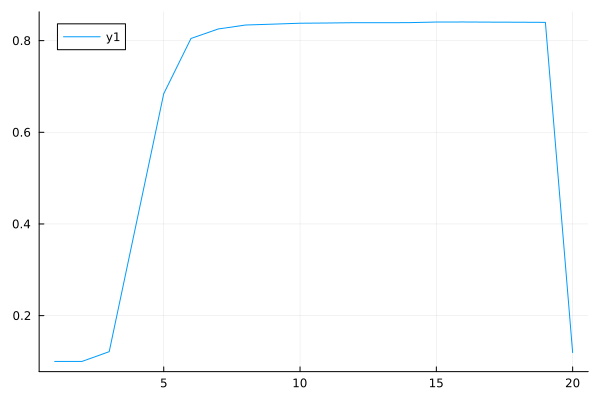

In [91]:
plot(sum(l2, dims=2) ./ spk_n)

# Test conventional network

In [ ]:
model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            Conv((16, 16), 1 => 3, relu),
            Conv((8, 8), 3 => 1, relu),
            FlattenLayer(),
            Dense(36 => 128, relu),
            Dense(128 => 10),
            softmax)

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#31),
    layer_3 = Conv((16, 16), 1 => 3, relu),       # 771 parameters
    layer_4 = Conv((8, 8), 3 => 1, relu),         # 193 parameters
    layer_5 = FlattenLayer{Nothing}(nothing),
    layer_6 = Dense(36 => 128, relu),             # 4_736 parameters
    layer_7 = Dense(128 => 10),                   # 1_290 parameters
    layer_8 = WrappedFunction(softmax),
)         # Total: 8_558 parameters,
          #        plus 0 states.

In [ ]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.019709477 0.0077816104 … 0.05482017 -0.08519609; -0.14134635 0.20817417 … 0.09868311 0.17127244; … ; -0.12946782 0.023861565 … -0.13425288 -0.19576402; 0.13110001 0.05310778 … 0.065689325 -0.13362738;;;; 0.15503614 -0.17867574 … -0.15539703 0.05237471; -0.045117833 -0.033451576 … -0.10569792 0.05006388; … ; 0.20915674 0.10383065 … -0.19610864 -0.039417222; 0.0066004097 0.08147644 … -0.11394326 -0.18828012;;;; -0.178612 0.08852646 … -0.07514592 0.18356745; -0.19098079 -0.19624312 … 0.21617825 0.037872236; … ; 0.052916326 0.07858618 … -0.15753508 0.15217651; -0.054194387 0.1918815 … 0.19596435 -0.07114898], bias = Float32[-0.027953401, 0.02774784, 0.031258054]), layer_4 = (weight = Float32[-0.20838591 -0.17065153 … 0.0936847

In [ ]:
size(x0)

(28, 28, 128)

In [ ]:
yp, _ = model(x0, ps, st);

In [ ]:
yp |> size

(10, 128)

In [ ]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [ ]:
loss_function(x0, y0, model, ps, st)

2.2924888f0

In [ ]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[2.2924886f0, 2.3081408f0, 2.31676f0, 2.3079188f0, 2.2901168f0, 2.3088775f0, 2.2803328f0, 2.301262f0, 2.312271f0, 2.3102589f0  …  0.46450445f0, 0.46338207f0, 0.3946164f0, 0.6191207f0, 0.5564805f0, 0.402021f0, 0.50196457f0, 0.47207898f0, 0.44010928f0, 0.3829913f0], (layer_1 = (bias = Float32[-0.13086447 -0.041049037 … 0.44468114 0.24080005; -0.21255781 0.14469881 … 0.10253736 -0.059274286; … ; -0.03787406 0.10376253 … -0.09813403 -0.11328661; -0.0067572724 -0.063981675 … -0.18527935 -0.06574187;;;], scale = Float32[1.128379 1.0418553 … 0.55189633 0.76034564; 1.2094455 0.85592246 … 0.8866003 1.0578705; … ; 1.035948 0.8976274 … 1.0675752 1.105976; 1.0105442 1.0593327 … 1.1779666 1.067004;;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[0.026016533 -0.0114520565 … 0.05540292 -0.16146557; -0.21074124 0.17065413 … 0.06871356 0.10181704; … ; -0.058543146 0.0813443 … -0.30666044 -0.4204357; 0.22652374 0.07915699 … -0.025637519 -0.3361033;;;; 0.16456749 -0.16410628 … -0.2307881 0.0

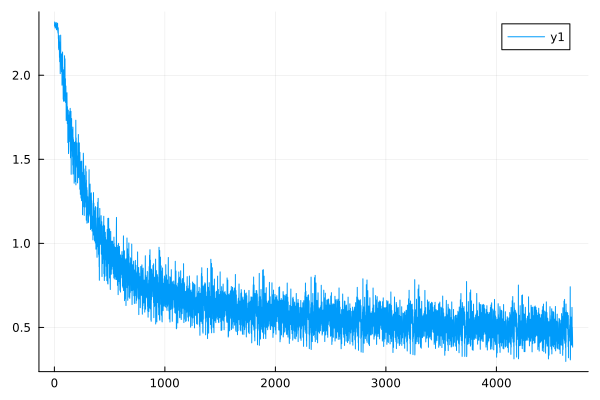

In [ ]:
plot(losses)

In [ ]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [ ]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [ ]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.1052

In [ ]:
test(model, test_loader, pst, stt)

0.8105